**Machine Learning Problem** : predict the revenue generated by the customer (in dollars) when s/he visits the store

**Ref Source** : https://www.kaggle.com/competitions/ga-customer-revenue-prediction/overview

Loading data from Kaggle : I downloaded my API token from Kaggle (kaggle.json) and ran the following commands to be able to download the data directly from Kaggle on Google Colab

Ref : https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c ga-customer-revenue-prediction

100% 1.56G/1.56G [00:22<00:00, 55.9MB/s]
100% 1.56G/1.56G [00:22<00:00, 74.0MB/s]


In [ ]:
! unzip ga-customer-revenue-prediction.zip

Archive:  ga-customer-revenue-prediction.zip
  inflating: sample_submission.csv   
  inflating: sample_submission_v2.csv  
  inflating: test.csv                
  inflating: test_v2.csv             
  inflating: train.csv               
  inflating: train_v2.csv            


Importing libraries we might need

In [ ]:
# importing libraries

import os
import json
import gc
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st

In [ ]:
#CODE HERE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from scipy.stats.mstats import winsorize
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

Quick data check

In [ ]:
df = pd.read_csv('/content/train_v2.csv', nrows=10)
df.head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8934116514970143966,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/a/google.com/transportation...",1508176307,6,1508176307
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",7992466427990357681,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1508201613,1,1508201613
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9075655783635761930,"{""continent"": ""Asia"", ""subContinent"": ""Western...","[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508169851,1,1508169851
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6960673291025684308,"{""continent"": ""Americas"", ""subContinent"": ""Cen...","[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508190552,1,1508190552


We can see that four features in the train & test datasets are in the JSON form - 'device', 'geoNetwork', 'totals', 'trafficSource. These features need to be flattened out. We have a refernce function written which I am going to be using for this : https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook

In [ ]:
def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in JSON_COLUMNS},
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows,
                     on_bad_lines='skip')

    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

Creating Train and Test Dataframes

Creating a smaller dataframe for the ease of use

We would be using Pandas Dataframe : for more information please read https://towardsdatascience.com/why-and-how-to-use-pandas-with-large-data-9594dda2ea4c

In [ ]:
small_train_df = load_df('/content/train_v2.csv', nrows = 100000)

<ipython-input-11-3a68f20ff476>:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  column_as_df = json_normalize(df[column])
<ipython-input-11-3a68f20ff476>:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  column_as_df = json_normalize(df[column])
<ipython-input-11-3a68f20ff476>:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  column_as_df = json_normalize(df[column])
<ipython-input-11-3a68f20ff476>:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  column_as_df = json_normalize(df[column])


Loaded train_v2.csv. Shape: (100000, 59)


Quick data check - makes use realize that there columns we can drop and

In [ ]:
small_train_df.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,...,water bottle,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,...,NaN,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,...,NaN,not available in demo dataset,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,1508169851,1,1508169851,Chrome,...,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,1508190552,1,1508190552,Chrome,...,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
small_train_df.nunique()

channelGrouping                                          8
customDimensions                                         6
date                                                    38
fullVisitorId                                        90097
hits                                                 93602
socialEngagementType                                     1
visitId                                              98072
visitNumber                                            210
visitStartTime                                       98062
device.browser                                          35
device.browserVersion                                    1
device.browserSize                                       1
device.operatingSystem                                  18
device.operatingSystemVersion                            1
device.isMobile                                          2
device.mobileDeviceBranding                              1
device.mobileDeviceModel                                

Getting a list of all the column names

In [ ]:
small_train_df.columns.to_list()

['channelGrouping',
 'customDimensions',
 'date',
 'fullVisitorId',
 'hits',
 'socialEngagementType',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'device.browser',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystem',
 'device.operatingSystemVersion',
 'device.isMobile',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'device.deviceCategory',
 'geoNetwork.continent',
 'geoNetwork.subContinent',
 'geoNetwork.country',
 'geoNetwork.region',
 'geoNetwork.metro',
 'geoNetwork.city',
 'geoNetwork.cityId',
 'geoNetwork.networkDomain',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.hits',
 'totals.pageviews',
 'totals.bounces',
 'totals.newVisits',
 'totals.sessionQualityDim',
 'totals.timeOnSite',
 'total

Check for each column how many unique values are present. If count is one, that means same value exists for that feature across the data-set. Hence that  feature will not help us for any kind of predictions. So we are drop those columns.

In [ ]:
small_train_df.nunique()

channelGrouping                                          8
customDimensions                                         6
date                                                    38
fullVisitorId                                        90097
hits                                                 93602
socialEngagementType                                     1
visitId                                              98072
visitNumber                                            210
visitStartTime                                       98062
device.browser                                          35
device.browserVersion                                    1
device.browserSize                                       1
device.operatingSystem                                  18
device.operatingSystemVersion                            1
device.isMobile                                          2
device.mobileDeviceBranding                              1
device.mobileDeviceModel                                

Create a list of columns we would want to drop

In [ ]:
column_names = small_train_df.columns.to_list()
unique_value_columns=[]
for column in column_names:
    count = small_train_df[column].nunique()
    if count==1:
        unique_value_columns.append(column)
print(unique_value_columns)

['socialEngagementType', 'device.browserVersion', 'device.browserSize', 'device.operatingSystemVersion', 'device.mobileDeviceBranding', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.flashVersion', 'device.language', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits', 'totals.bounces', 'totals.newVisits', 'trafficSource.adwordsClickInfo.criteriaParameters', 'trafficSource.isTrueDirect', 'trafficSource.adwordsClickInfo.isVideoAd']


Analysis of missing values. Here we are checking in each colummn how much percentage of data missed

Credits : https://stackoverflow.com/questions/51070985/find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset

In [ ]:
percent_missing = small_train_df.isnull().sum() * 100 / len(small_train_df)  #{ (total nulls in particular column*100)/total no.of rows }
missing_value = pd.DataFrame({'column_name': small_train_df.columns, 'percent_missing': percent_missing})

In [ ]:
missing_value

,column_name,percent_missing
channelGrouping,channelGrouping,0.000
customDimensions,customDimensions,0.000
date,date,0.000
fullVisitorId,fullVisitorId,0.000
hits,hits,0.000
socialEngagementType,socialEngagementType,0.000
visitId,visitId,0.000
visitNumber,visitNumber,0.000
visitStartTime,visitStartTime,0.000
device.browser,device.browser,0.000


In [ ]:
len(small_train_df.columns)

29

In [ ]:
def clean_df(df):
  # drop features where same value exists through the dataset
  column_names = df.columns.to_list()
  for column in column_names:
      count = df[column].nunique()
      if count==1:
          df = df.drop(columns=column)

  # drop transactionRevenue, use "totals.totalTransactionRevenue" instead
  df = df.drop(columns='totals.transactionRevenue')

  # fill in empty rows
  df["totals.totalTransactionRevenue"] = df["totals.totalTransactionRevenue"].fillna("0").astype(float)
  df["totals.pageviews"] = df["totals.pageviews"].fillna(0).astype(int)
  df["totals.sessionQualityDim"] = df["totals.sessionQualityDim"].fillna("1").astype(int)

  # drop columns with a higher percentage of missing values that can't be filled in
  # as these features would not be of much use to us
  df = df.drop(columns='trafficSource.adwordsClickInfo.page')
  df = df.drop(columns='trafficSource.adwordsClickInfo.slot')
  df = df.drop(columns='trafficSource.adwordsClickInfo.gclId')
  df = df.drop(columns='trafficSource.adwordsClickInfo.adNetworkType')
  df = df.drop(columns='trafficSource.keyword')
  df = df.drop(columns='trafficSource.referralPath')
  df = df.drop(columns='trafficSource.adContent')
  return df

In [ ]:
small_train_df = clean_df(small_train_df)

In [ ]:
small_train_df

,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,...,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508198450,1,1508198450,Firefox,Windows,...,(not set),1,1,1,NaN,NaN,0.0,(not set),google,organic
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1508176307,6,1508176307,Chrome,Chrome OS,...,(not set),2,2,2,28,NaN,0.0,(not set),sites.google.com,referral
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508201613,1,1508201613,Chrome,Android,...,windjammercable.net,2,2,1,38,NaN,0.0,(not set),(direct),(none)
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",1508169851,1,1508169851,Chrome,Windows,...,unknown.unknown,2,2,1,1,NaN,0.0,(not set),google,organic
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",1508190552,1,1508190552,Chrome,Windows,...,prod-infinitum.com.mx,2,2,1,52,NaN,0.0,(not set),google,organic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Direct,"[{'index': '4', 'value': 'Central America'}]",20170529,9959129121135955735,"[{'hitNumber': '1', 'time': '0', 'hour': '22',...",1496122172,1,1496122172,Chrome,Windows,...,cableonline.com.mx,14,10,1,168,NaN,0.0,(not set),(direct),(none)
99996,Referral,"[{'index': '4', 'value': 'North America'}]",20170529,4458329221243726234,"[{'hitNumber': '1', 'time': '0', 'hour': '12',...",1496087028,22,1496087028,Chrome,Chrome OS,...,(not set),15,13,1,255,1,50380000.0,(not set),(direct),(none)
99997,Organic Search,"[{'index': '4', 'value': 'North America'}]",20170529,4543741255333262,"[{'hitNumber': '1', 'time': '0', 'hour': '19',...",1496112576,2,1496112576,Chrome,Chrome OS,...,telus.net,15,15,1,360,NaN,0.0,(not set),google,organic
99998,Social,"[{'index': '4', 'value': 'North America'}]",20170529,0994272213284505294,"[{'hitNumber': '1', 'time': '0', 'hour': '21',...",1496120385,2,1496120385,Internet Explorer,Windows,...,(not set),15,14,1,431,1,49990000.0,(not set),facebook.com,referral


In [ ]:
# rename the columns that were extracted from the jsons to make them cleaner
small_train_df = small_train_df.rename(columns={
      "device.browser": "browser",
      "device.operatingSystem": "operatingSystem",
      "device.isMobile": "isMobile",
      "device.deviceCategory": "deviceCategory",
      "geoNetwork.continent": "continent",
      "geoNetwork.subContinent": "subContinent",
      "geoNetwork.country": "country",
      "geoNetwork.region": "region",
      "geoNetwork.metro": "metro",
      "geoNetwork.city": "city",
      "geoNetwork.networkDomain": "networkDomain",
      "totals.hits": "hits",
      "totals.pageviews": "pageviews",
      "totals.sessionQualityDim": "sessionQualityDim",
      "totals.timeOnSite": "timeOnSite",
      "totals.transactions": "transactions",
      "totals.totalTransactionRevenue": "totalTransactionRevenue",
      "trafficSource.campaign": "campaign",
      "trafficSource.source": "source",
      "trafficSource.medium": "medium"})

In [ ]:
small_train_df.columns.to_list()

['channelGrouping',
 'customDimensions',
 'date',
 'fullVisitorId',
 'hits',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'browser',
 'operatingSystem',
 'isMobile',
 'deviceCategory',
 'continent',
 'subContinent',
 'country',
 'region',
 'metro',
 'city',
 'networkDomain',
 'hits',
 'pageviews',
 'sessionQualityDim',
 'timeOnSite',
 'transactions',
 'totalTransactionRevenue',
 'campaign',
 'source',
 'medium']

# Exploratory Data Analysis

**Target Variable Analysis**

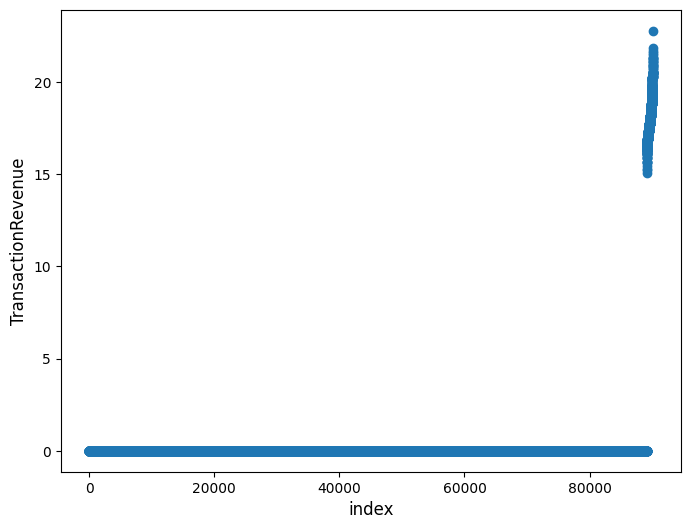

In [ ]:
small_train_df["totalTransactionRevenue"] = small_train_df["totalTransactionRevenue"].astype('float')
# for each user we are taking sum of all their transactions
sum = small_train_df.groupby("fullVisitorId")["totalTransactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(sum.shape[0]), np.sort(np.log1p(sum["totalTransactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

Here we see the 80/20 rule in action where any business's revenue comes from a tiny fraction of it's users

**Trend over time Analysis**

Plot for number of visits to the site over time

In [ ]:
# convert date feature into exact date format
small_train_df["date"] = pd.to_datetime(small_train_df["date"], infer_datetime_format=True, format="%Y%m%d")


In [ ]:
# Compute count of group, excluding missing values(include only non zero values).
group_date = small_train_df.groupby('date').count()
group_date.reset_index(inplace=True)

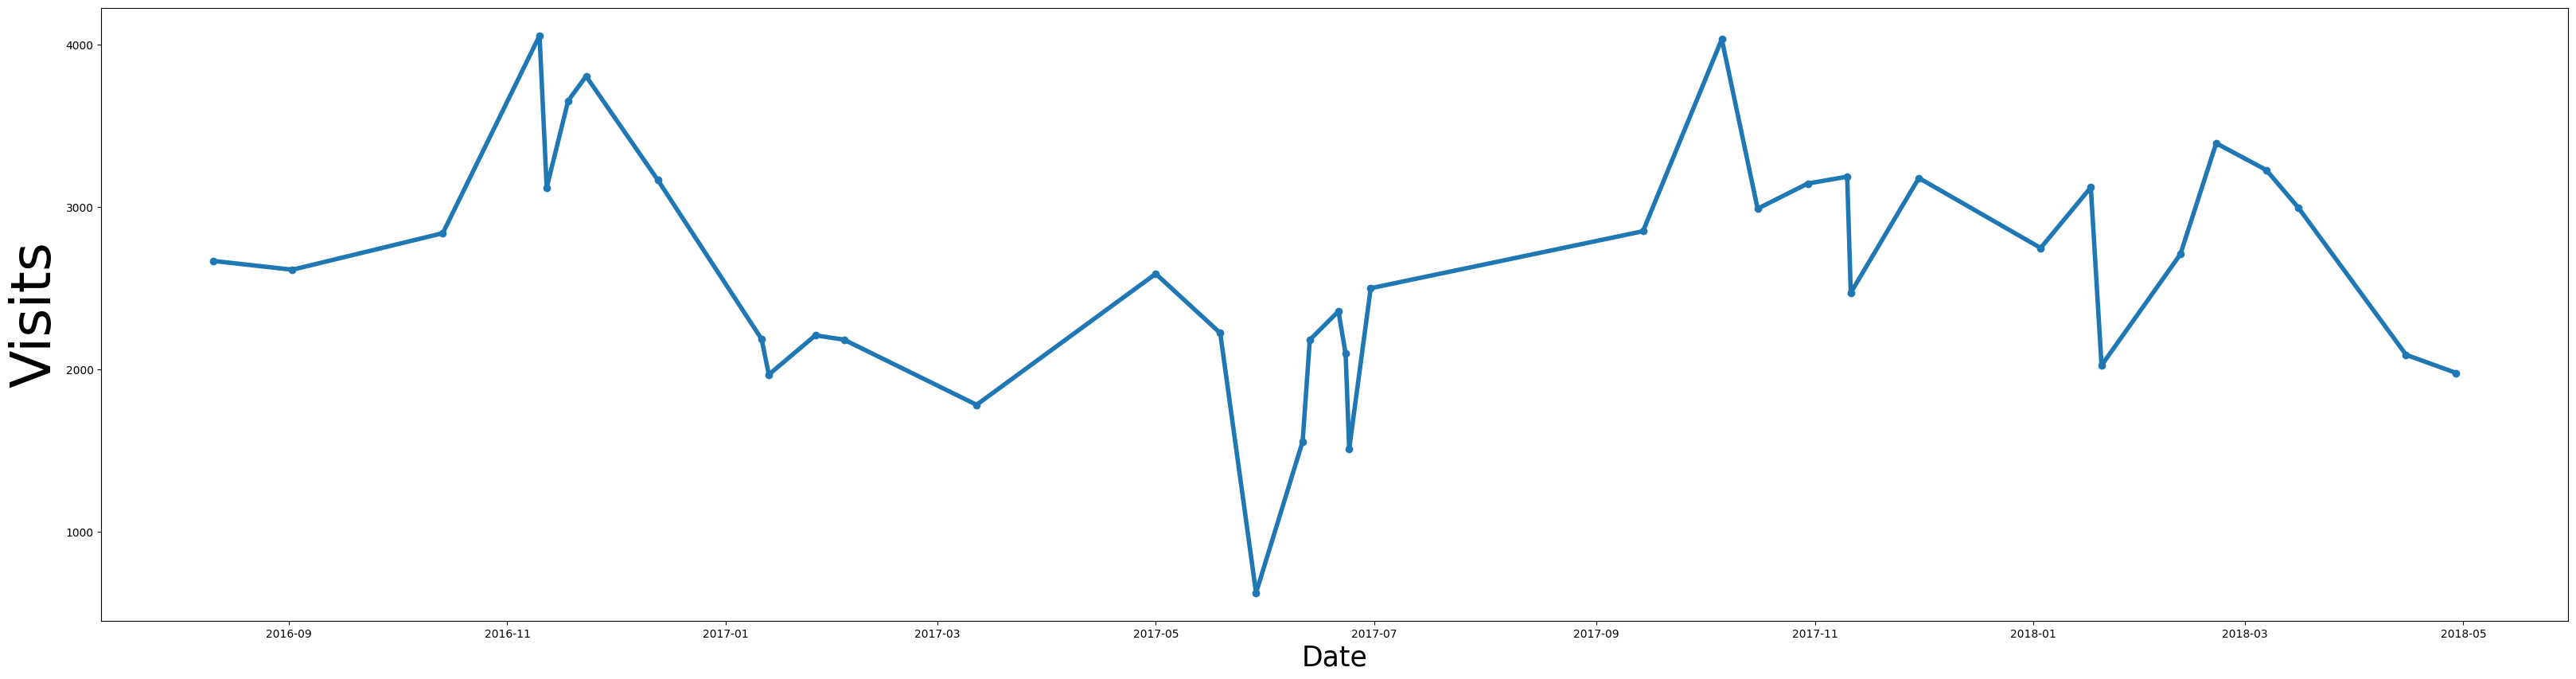

In [ ]:
plt.figure(figsize=(40,10))
plt.plot_date(x = group_date['date'], y = group_date['fullVisitorId'],linestyle='solid',linewidth=4)
plt.xlabel('Date',fontsize=25)
plt.ylabel('Visits',fontsize=50)
plt.rc('xtick', labelsize=40)
plt.rc('ytick', labelsize=40)
plt.autoscale(True)
plt.show()

TO DO : Plot of number of non-zero transactions on the site over time

In [ ]:
small_train_df.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,browser,operatingSystem,...,networkDomain,hits,pageviews,sessionQualityDim,timeOnSite,transactions,totalTransactionRevenue,campaign,source,medium
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",2017-10-16,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508198450,1,1508198450,Firefox,Windows,...,(not set),1,1,1,NaN,NaN,0.0,(not set),google,organic
1,Referral,"[{'index': '4', 'value': 'North America'}]",2017-10-16,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1508176307,6,1508176307,Chrome,Chrome OS,...,(not set),2,2,2,28,NaN,0.0,(not set),sites.google.com,referral
2,Direct,"[{'index': '4', 'value': 'North America'}]",2017-10-16,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508201613,1,1508201613,Chrome,Android,...,windjammercable.net,2,2,1,38,NaN,0.0,(not set),(direct),(none)
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",2017-10-16,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",1508169851,1,1508169851,Chrome,Windows,...,unknown.unknown,2,2,1,1,NaN,0.0,(not set),google,organic
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",2017-10-16,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",1508190552,1,1508190552,Chrome,Windows,...,prod-infinitum.com.mx,2,2,1,52,NaN,0.0,(not set),google,organic


Data Type

In [ ]:
print(small_train_df.dtypes)

channelGrouping                    object
customDimensions                   object
date                       datetime64[ns]
fullVisitorId                      object
hits                               object
visitId                             int64
visitNumber                         int64
visitStartTime                      int64
browser                            object
operatingSystem                    object
isMobile                             bool
deviceCategory                     object
continent                          object
subContinent                       object
country                            object
region                             object
metro                              object
city                               object
networkDomain                      object
hits                               object
pageviews                           int64
sessionQualityDim                   int64
timeOnSite                         object
transactions                      

Number of non-zero transactions over time

In [ ]:
# Group by 'date' and count non-zero transactions
non_zero_transactions_over_time = small_train_df[small_train_df['transactions'] != 0].groupby('date')['transactions'].count()

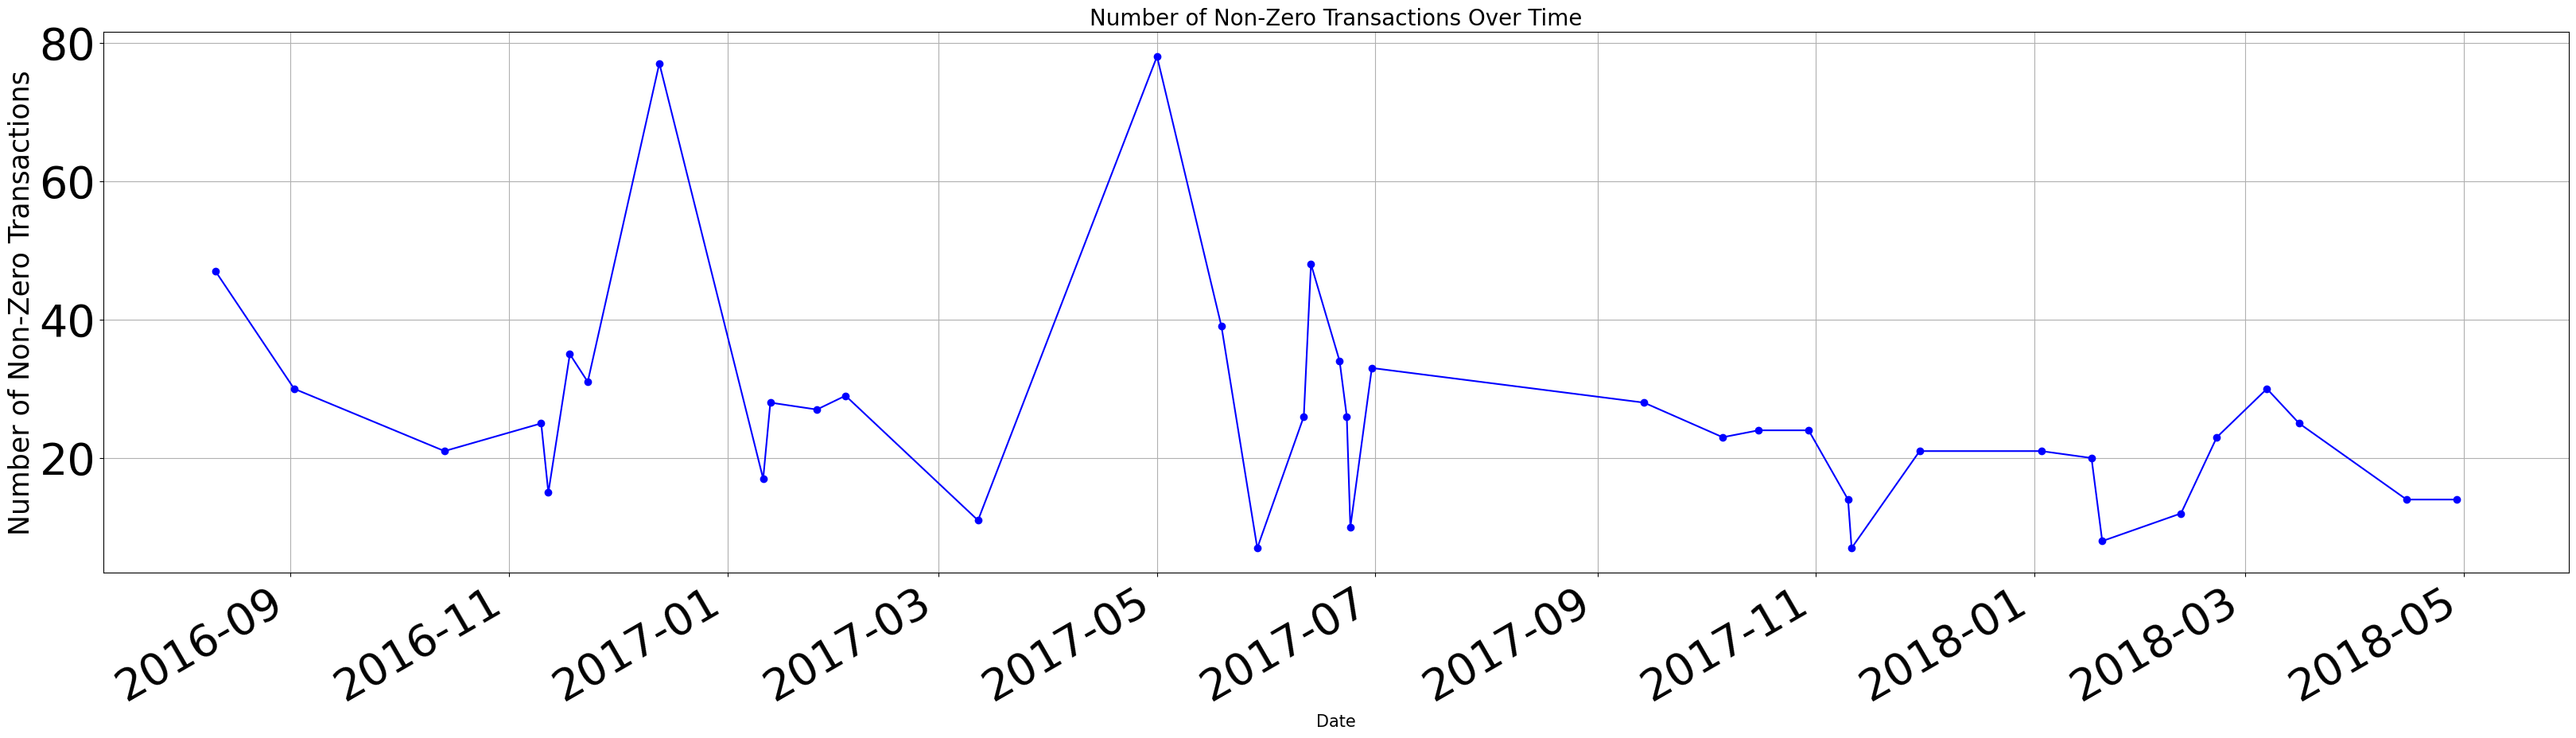

In [ ]:
# Plot the number of non-zero transactions over time
plt.figure(figsize=(40, 10))
non_zero_transactions_over_time.plot(kind='line', marker='o', linestyle='-', color='b')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of Non-Zero Transactions', fontsize=25)
plt.title('Number of Non-Zero Transactions Over Time', fontsize=20)
plt.grid(True)
plt.show()

Visits per channel

In [ ]:
small_train_df['channelGrouping'].unique()

array(['Organic Search', 'Referral', 'Direct', 'Paid Search', 'Display',
       'Affiliates', 'Social', '(Other)'], dtype=object)

In [ ]:
len(small_train_df['channelGrouping'].unique())

8

Total revenue generated per channel

In [ ]:
#_per_channel = small_train_df[small_train_df['totalTransactionRevenue'] != 0].groupby('channelGrouping')['fullVisitorId'].count()
totalrevenue_per_channel = small_train_df.groupby('channelGrouping')['totalTransactionRevenue'].count().reset_index()

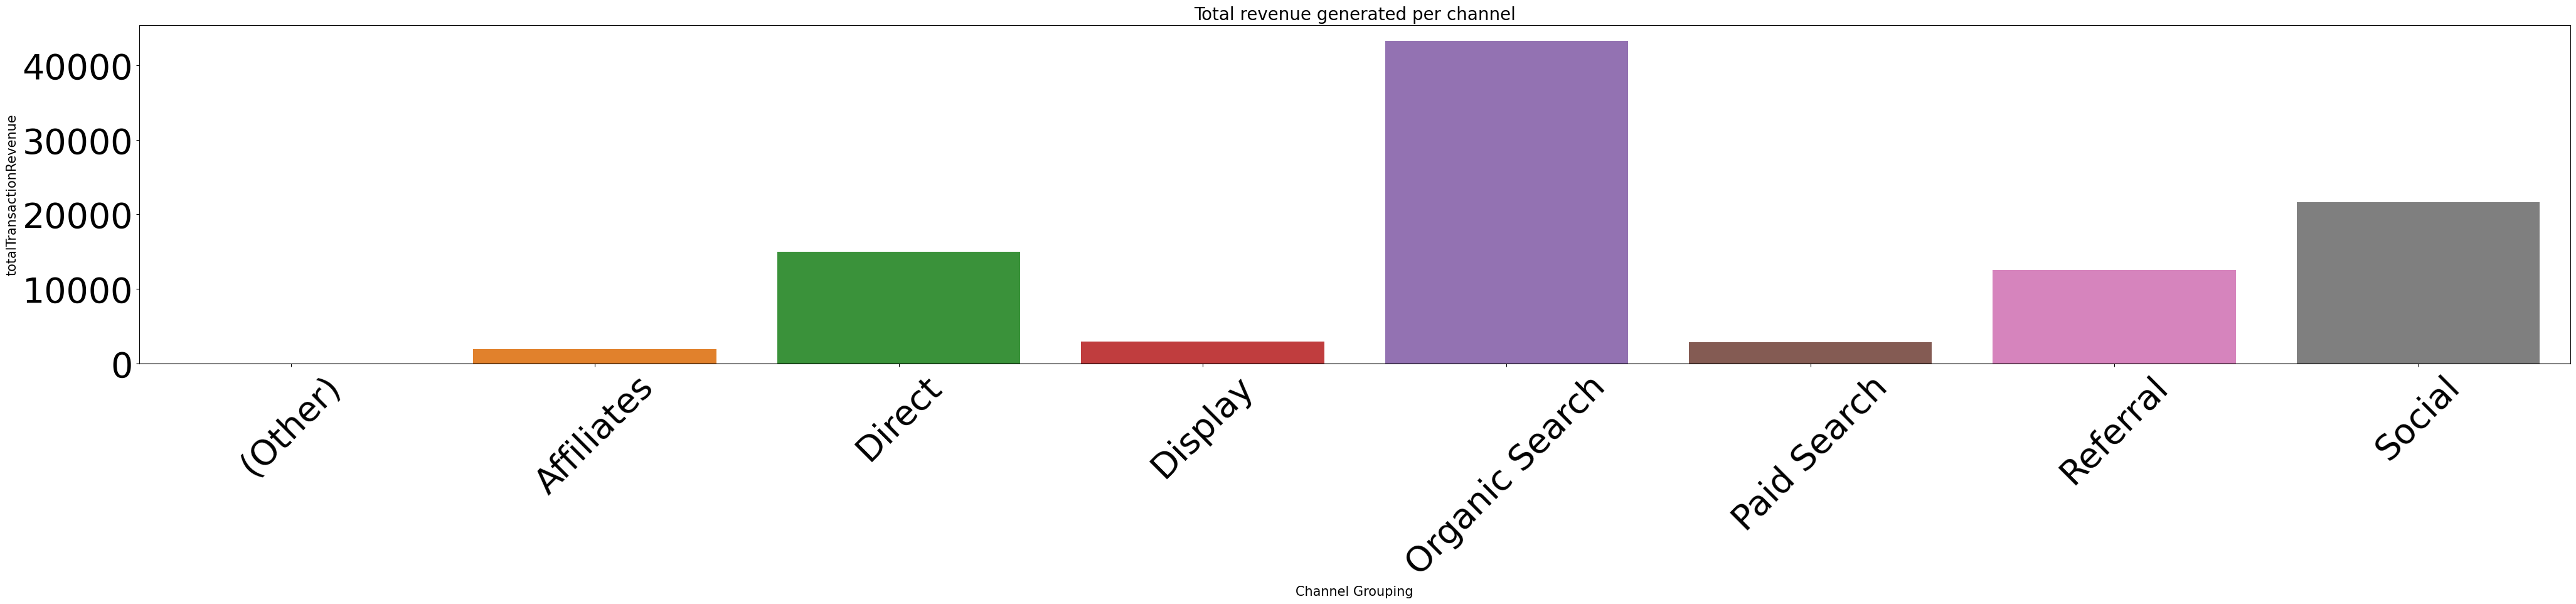

In [ ]:
fig1 = plt.figure(figsize=(50,7)) #this is to rescale an image so that it is easier to read
ax = sns.barplot(data= totalrevenue_per_channel, x='channelGrouping', y='totalTransactionRevenue')
plt.xticks(rotation=45)  # Rotate the x-axis tick labels
plt.xlabel('Channel Grouping', fontsize=15)  # Add the x-axis label
plt.ylabel('totalTransactionRevenue', fontsize=15)  # Add the y-axis label
plt.title('Total revenue generated per channel', fontsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.show()  # Display the plot

In [ ]:
max(small_train_df['totalTransactionRevenue'])

5501000000.0

Total revenue generated per channel web browser

In [ ]:
totalrevenue_per_web_browser = small_train_df.groupby('browser')['totalTransactionRevenue'].count().reset_index()

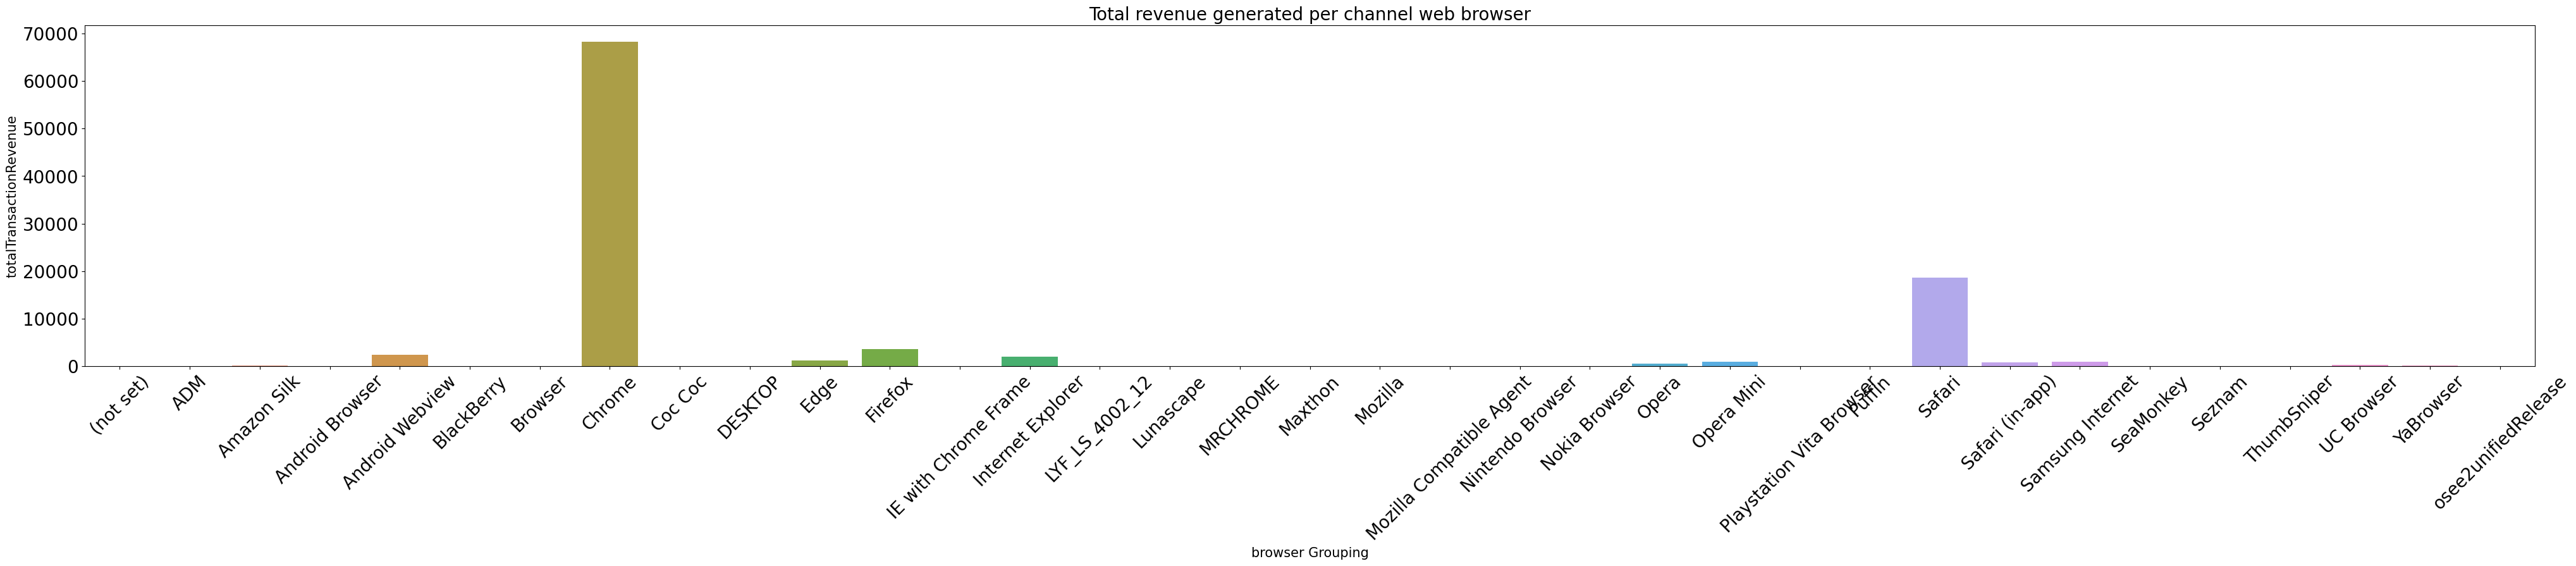

In [ ]:
fig1 = plt.figure(figsize=(50,7)) #this is to rescale an image so that it is easier to read
ax = sns.barplot(data= totalrevenue_per_web_browser, x='browser', y='totalTransactionRevenue')
plt.xticks(rotation=45)  # Rotate the x-axis tick labels
plt.xlabel('browser Grouping', fontsize=15)  # Add the x-axis label
plt.ylabel('totalTransactionRevenue', fontsize=15)  # Add the y-axis label
plt.title('Total revenue generated per channel web browser', fontsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.show()  # Display the plot

Total revenue generated per channel device category

In [ ]:
totalrevenue_per_web_browser = small_train_df.groupby('deviceCategory')['totalTransactionRevenue'].count().reset_index()
device_size = [0.2]
point_sizes = [size * 10000 for size in device_size]

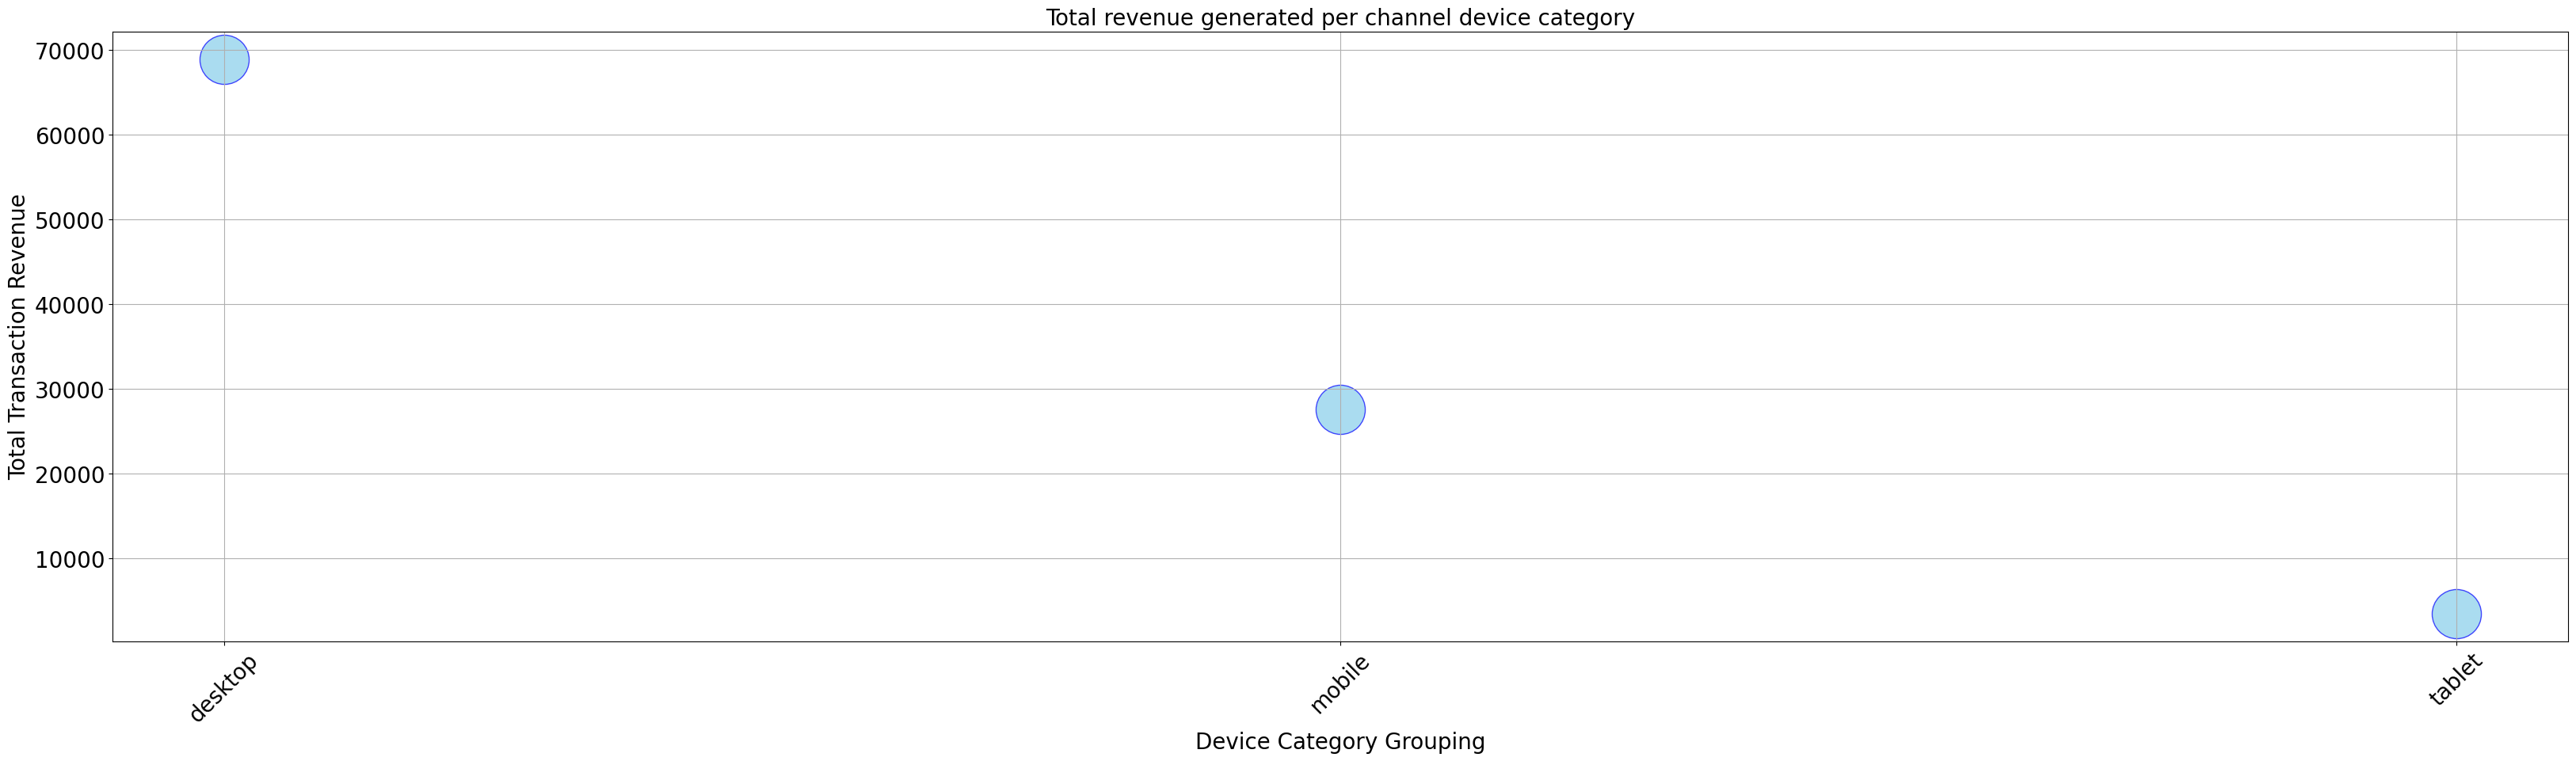

In [ ]:
plt.figure(figsize=(40,10)) #Set the figure size
plt.scatter(data= totalrevenue_per_web_browser, x='deviceCategory', s= point_sizes, y='totalTransactionRevenue', c = 'skyblue', alpha = 0.7, edgecolors= 'b')

#Add labels, a title, and a Legend
plt.xlabel('deviceCategory')
plt.ylabel('totalTransactionRevenue')
plt.xticks(rotation=45)  # Rotate the x-axis tick labels
plt.title('Total revenue generated per channel device category',fontsize=20)
plt.xlabel('Device Category Grouping', fontsize=20)  # Add the x-axis label
plt.ylabel('Total Transaction Revenue', fontsize=20)  # Add the y-axis label
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.grid(True)
plt.show()

Data Cleaning

**Missing Data**



In [ ]:
small_train_df.isnull().values.any()

True

In [ ]:
nan_count = np.sum(small_train_df.isnull(), axis = 0)
nan_count

channelGrouping                0
customDimensions               0
date                           0
fullVisitorId                  0
hits                           0
visitId                        0
visitNumber                    0
visitStartTime                 0
browser                        0
operatingSystem                0
isMobile                       0
deviceCategory                 0
continent                      0
subContinent                   0
country                        0
region                         0
metro                          0
city                           0
networkDomain                  0
hits                           0
pageviews                      0
sessionQualityDim              0
timeOnSite                 49974
transactions               98998
totalTransactionRevenue        0
campaign                       0
source                         0
medium                         0
dtype: int64

In [ ]:
condition = nan_count != 0 # look for all columns with missing values

col_names = nan_count[condition].index # get the column names
print(col_names)

nan_cols = list(col_names) # convert column names to list
print(nan_cols)

Index(['timeOnSite', 'transactions'], dtype='object')
['timeOnSite', 'transactions']


**Choose Which Values to Fill**

In [ ]:
nan_col_types = small_train_df[nan_cols].dtypes
nan_col_types

timeOnSite      object
transactions    object
dtype: object

These columns are identified as type object

**Create 'Dummy' Variables for Missing Values**

In [ ]:
small_train_df['timeOnSite_na'] = small_train_df['timeOnSite'].isnull()
small_train_df['transactions'] = small_train_df['transactions'].isnull()
small_train_df.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,browser,operatingSystem,...,hits,pageviews,sessionQualityDim,timeOnSite,transactions,totalTransactionRevenue,campaign,source,medium,timeOnSite_na
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",2017-10-16,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508198450,1,1508198450,Firefox,Windows,...,1,1,1,NaN,True,0.0,(not set),google,organic,True
1,Referral,"[{'index': '4', 'value': 'North America'}]",2017-10-16,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1508176307,6,1508176307,Chrome,Chrome OS,...,2,2,2,28,True,0.0,(not set),sites.google.com,referral,False
2,Direct,"[{'index': '4', 'value': 'North America'}]",2017-10-16,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508201613,1,1508201613,Chrome,Android,...,2,2,1,38,True,0.0,(not set),(direct),(none),False
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",2017-10-16,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",1508169851,1,1508169851,Chrome,Windows,...,2,2,1,1,True,0.0,(not set),google,organic,False
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",2017-10-16,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",1508190552,1,1508190552,Chrome,Windows,...,2,2,1,52,True,0.0,(not set),google,organic,False


In [ ]:
small_train_df['timeOnSite'] = small_train_df['timeOnSite'].astype(float)

**Fill the Missing Values**

In [ ]:
# compute mean for all non null timeOnSite values
mean_timeOnSite = small_train_df['timeOnSite'].mean()
print("mean value for all timeOnSite columns: " + str(mean_timeOnSite))

# fill all missing values with the mean
small_train_df['timeOnSite'].fillna(value=mean_timeOnSite, inplace=True)

# compute mean for all non null transactions values
mean_transactions=small_train_df['transactions'].mean()
print("mean value for all transactions columns: " + str(mean_transactions))

# fill all missing values with the mean
small_train_df['transactions'].fillna(value=mean_transactions, inplace=True)

mean value for all timeOnSite columns: 241.9510854355735
mean value for all transactions columns: 0.98998


In [ ]:
small_train_df.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,browser,operatingSystem,...,hits,pageviews,sessionQualityDim,timeOnSite,transactions,totalTransactionRevenue,campaign,source,medium,timeOnSite_na
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",2017-10-16,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508198450,1,1508198450,Firefox,Windows,...,1,1,1,241.951085,True,0.0,(not set),google,organic,True
1,Referral,"[{'index': '4', 'value': 'North America'}]",2017-10-16,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1508176307,6,1508176307,Chrome,Chrome OS,...,2,2,2,28.000000,True,0.0,(not set),sites.google.com,referral,False
2,Direct,"[{'index': '4', 'value': 'North America'}]",2017-10-16,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508201613,1,1508201613,Chrome,Android,...,2,2,1,38.000000,True,0.0,(not set),(direct),(none),False
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",2017-10-16,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",1508169851,1,1508169851,Chrome,Windows,...,2,2,1,1.000000,True,0.0,(not set),google,organic,False
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",2017-10-16,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",1508190552,1,1508190552,Chrome,Windows,...,2,2,1,52.000000,True,0.0,(not set),google,organic,False


In [ ]:
nan_count = np.sum(small_train_df.isnull(), axis = 0)
nan_count

channelGrouping            0
customDimensions           0
date                       0
fullVisitorId              0
hits                       0
visitId                    0
visitNumber                0
visitStartTime             0
browser                    0
operatingSystem            0
isMobile                   0
deviceCategory             0
continent                  0
subContinent               0
country                    0
region                     0
metro                      0
city                       0
networkDomain              0
hits                       0
pageviews                  0
sessionQualityDim          0
timeOnSite                 0
transactions               0
totalTransactionRevenue    0
campaign                   0
source                     0
medium                     0
timeOnSite_na              0
dtype: int64

In [ ]:
small_train_df.dtypes

channelGrouping                    object
customDimensions                   object
date                       datetime64[ns]
fullVisitorId                      object
hits                               object
visitId                             int64
visitNumber                         int64
visitStartTime                      int64
browser                            object
operatingSystem                    object
isMobile                             bool
deviceCategory                     object
continent                          object
subContinent                       object
country                            object
region                             object
metro                              object
city                               object
networkDomain                      object
hits                               object
pageviews                           int64
sessionQualityDim                   int64
timeOnSite                        float64
transactions                      

**Finding and replacing outliers**

In [ ]:
from scipy.stats.mstats import winsorize

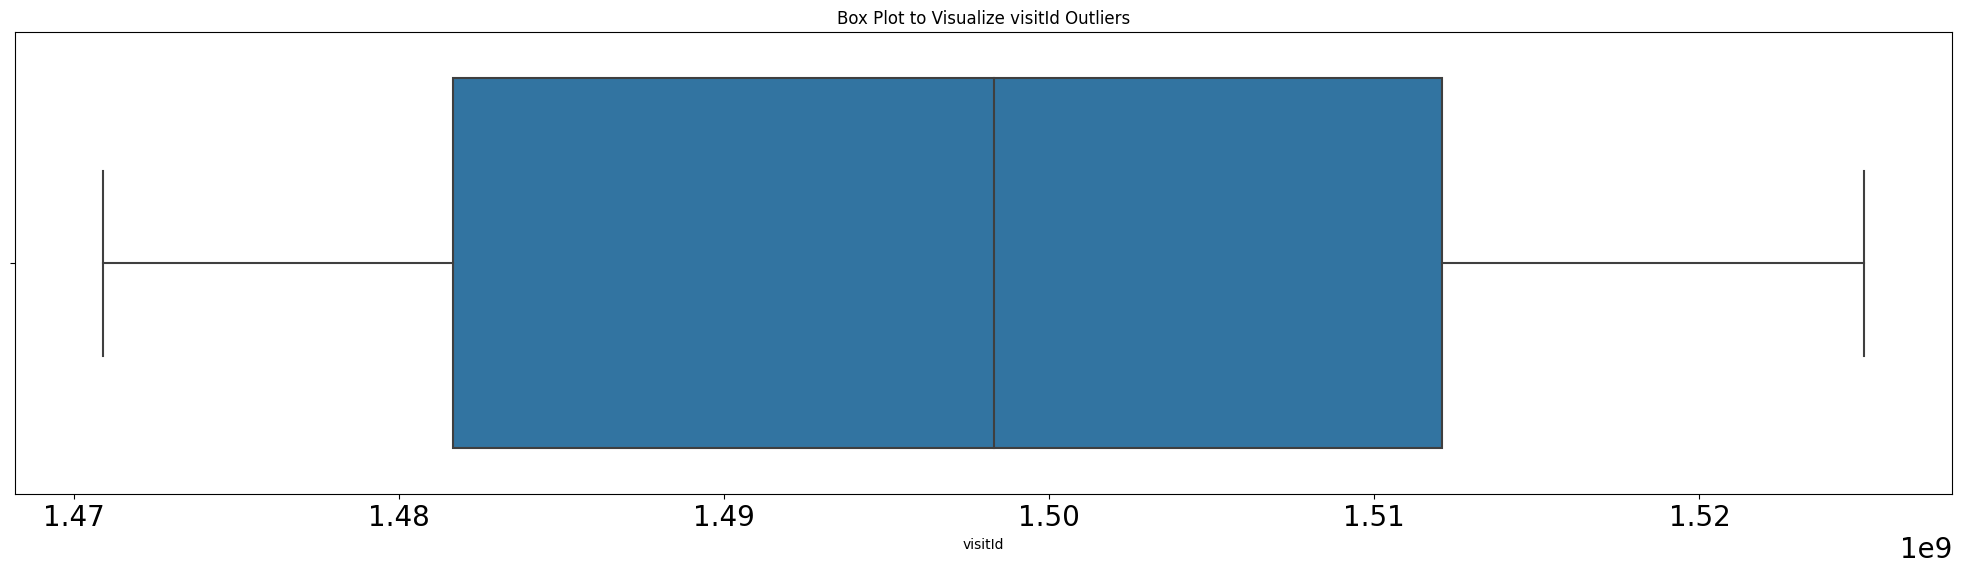

In [ ]:
plt.figure(figsize=(25, 6))
ax = sns.boxplot( x ='visitId', data=small_train_df)

# Optional: Add a title and labels
plt.title('Box Plot to Visualize visitId Outliers')

# Show the plot
plt.show()

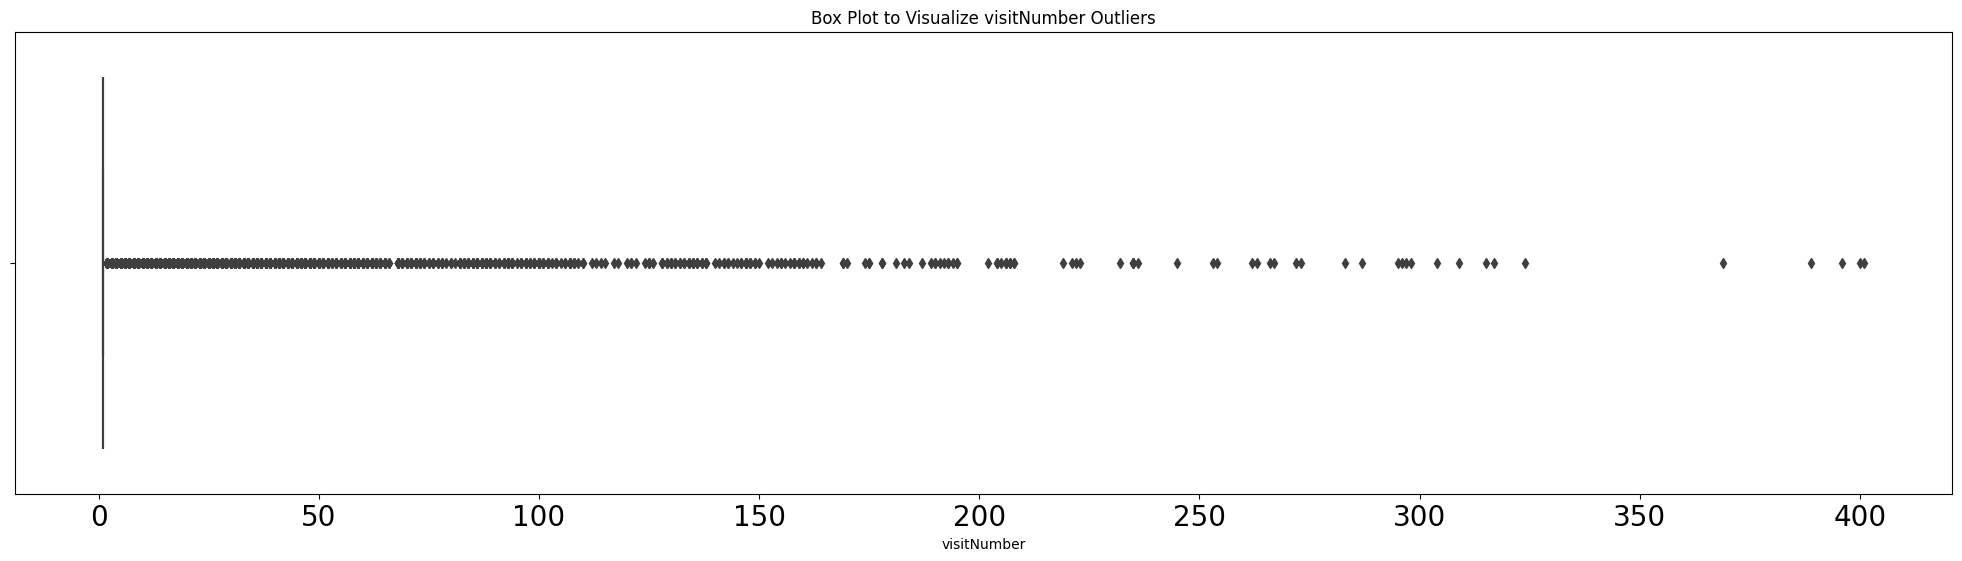

In [ ]:
plt.figure(figsize=(25, 6))
ax = sns.boxplot( x ='visitNumber', data=small_train_df)

# Optional: Add a title and labels
plt.title('Box Plot to Visualize visitNumber Outliers')

# Show the plot
plt.show()

In [ ]:
#creating a copy of a given column, such that the outlier values will be replaced.

# Winsorize the data
winsorized_data = winsorize(small_train_df['visitNumber'], limits=[0.01, 0.01])

# Replace the original column with the winsorized data in the DataFrame
df['visitNumber'] = winsorized_data


ValueError: Length of values (100000) does not match length of index (10)

In [ ]:
plt.figure(figsize=(25, 6))
ax = sns.boxplot( x ='visitStartTime', data=small_train_df)

# Optional: Add a title and labels
plt.title('Box Plot to Visualize visitStartTime Outliers')

# Show the plot
plt.show()

In [ ]:
plt.figure(figsize=(25, 6))
ax = sns.boxplot( x ='pageviews', data=small_train_df)

# Optional: Add a title and labels
plt.title('Box Plot to Visualize Page views Outliers')

# Show the plot
plt.show()

In [ ]:
#creating a copy of a given column, such that the outlier values will be replaced.

# Winsorize the data
winsorized_data = winsorize(small_train_df['pageviews'], limits=[0.01, 0.01])

# Replace the original column with the winsorized data in the DataFrame
df['pageviews'] = winsorized_data

In [ ]:
plt.figure(figsize=(25, 6))
ax = sns.boxplot( x ='sessionQualityDim', data=small_train_df)

# Optional: Add a title and labels
plt.title('Box Plot to Visualize Session QualityDim Outliers')

# Show the plot
plt.show()

In [ ]:
plt.figure(figsize=(25, 6))
ax = sns.boxplot( x ='timeOnSite', data=small_train_df)

# Optional: Add a title and labels
plt.title('Box Plot to Visualize timeOnSite Outliers')

# Show the plot
plt.show()

In [ ]:
#creating a copy of a given column, such that the outlier values will be replaced.

# Winsorize the data
winsorized_data = winsorize(small_train_df['timeOnSite'], limits=[0.01, 0.01])

# Replace the original column with the winsorized data in the DataFrame
df['timeOnSite'] = winsorized_data

In [ ]:
plt.figure(figsize=(25, 6))
ax = sns.boxplot( x ='totalTransactionRevenue', data=small_train_df)

# Optional: Add a title and labels
plt.title('Box Plot to Visualize Total Transaction Revenue Outliers')

# Show the plot
plt.show()

**One-hot encoding**

In [ ]:
small_train_df['browser'].value_counts().index[:3]

In [ ]:
other = small_train_df['browser'].value_counts().index[3:]

In [ ]:
drop_cols = ['hits',
 'subContinent',
 'country',
 'region',
 'metro',
 'city',
 'networkDomain',
 'hits',
 'transactions',
 'campaign']

In [ ]:
# drop the drop_cols column
small_train_df = small_train_df.drop(columns=['hits',
 'subContinent',
 'country',
 'region',
 'metro',
 'city',
 'networkDomain',
 'hits',
 'transactions',
 'campaign'], inplace=True)

In [ ]:
#small_train_df.head()

In [ ]:
features = small_train_df[['channelGrouping ', 'customDimensions', ]]
dummies_features = pd.get_dummies(features)

**Model testing**

In [ ]:
small_train_dff = pd.read_csv('clean_df2.csv', header = 0)

small_train_dff.head()

In [ ]:
small_train_dff['fullVisitorId_count'] = small_train_dff.groupby('fullVisitorId').transform('size')

In [ ]:
small_train_dff[['fullVisitorId_count', 'visitNumber']].head(20)

In [ ]:
def returnBoolean(value):
  if value <= 1:
    return 0
  else:
    return 1

small_train_dff['Return?'] = small_train_dff['fullVisitorId_count'].apply(returnBoolean)

In [ ]:
def returnBoolean(row):
    if row['fullVisitorId_count'] >= 2 and row['Spend?'] >= 0:
        return 1
    else:
        return 0

small_train_dff['Return&Spend'] = small_train_dff.apply(returnBoolean, axis=1)

In [ ]:
small_train_dff.head()

In [ ]:
small_test_dff = pd.read_csv('test_v2.csv', header = 0)

In [ ]:
small_test_dff.head()

In [ ]:
y_train = small_train_dff['totalTransactionRevenue']
X_train = small_train_dff.drop(columns =['totalTransactionRevenue'], axis = 1)

print("Number of examples: " + str(X_train.shape[0]))
print("\nNumber of Features:" + str(X_train.shape[1]))
print(str(list(X_train.columns)))

In [ ]:
y_test = small_test_dff['totalTransactionRevenue']
X_test = small_test_dff.drop(columns =['totalTransactionRevenue'], axis = 1)

print("Number of examples: " + str(X_test.shape[0]))
print("\nNumber of Features:" + str(X_test.shape[1]))
print(str(list(X_test.columns)))

**LINEAR REGRESSION**

In [ ]:
df1 = pd.read_csv('small_train_df1.csv')
df1.head()

In [ ]:
#X = pd.read_csv('X_top10df.csv')
#X.head()

In [ ]:
#df.dtypes

In [ ]:
#df['fullVisitorId'] = df['fullVisitorId'].astype(str)


In [ ]:
#y = pd.read_csv('Y_top10df.csv')
#y.head()

In [ ]:
#y = df1['totalTransactionRevenue'].reset_index(drop=True)
#X = df1.drop('totalTransactionRevenue', axis=1)

In [ ]:
#y.head()

In [ ]:
# Splitting the empty dataset
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)


In [ ]:
X_reshaped = X_train.values.reshape(-1, 1)

In [ ]:
X_reshaped.shape

In [ ]:
y_tran1 = y_train.values

In [ ]:
y_train.shape

In [ ]:
#y_train = np.array(y, dtype=float).reshape(-1, 1)

In [ ]:
#X_train1 = np.array(X_train, dtype=float)

In [ ]:
#from google.colab import files
#y_train.to_csv('y_train.csv', index=False)
#files.download('y_train.csv')

In [ ]:
# Creating and fitting the model using the training data
#model = LinearRegression()
#model.fit(X_train, y_train)

# Making predictions on the test set
#y_pred = model.predict(X_test)

# Calculating metrics on the test set
#mse = mean_squared_error(y_test, y_pred)
#rmse = np.sqrt(mse)
#r2 = r2_score(y_test, y_pred)

#print(f'Mean Squared Error: {mse:.2f}')
#print(f'Root Mean Squared Error: {rmse:.2f}')
#print(f'R-squared score: {r2:.2f}')

In [ ]:
#X_train1['fullVisitorId'] = X_train1['fullVisitorId'].astype(int)

In [ ]:
import statsmodels.api as sm

In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df1 is your DataFrame with 'totalTransactionRevenue' and other features
# You may need to preprocess your data accordingly

# Split the data into features (X) and target variable (y)
y = df1['totalTransactionRevenue']
X = df1.drop('totalTransactionRevenue', axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add a constant term to the features for the intercept (only for training sets)
X_train_final = sm.add_constant(X_train)
X_test_final = sm.add_constant(X_test)

# Standardize the features (optional but often recommended)
scaler = StandardScaler()
X_train_final_scaled = scaler.fit_transform(X_train_final)
X_test_final_scaled = scaler.transform(X_test_final)

# Fit the GLM
glm_model = sm.GLM(y_train, X_train_final_scaled, family=sm.families.Gaussian())
glm_results = glm_model.fit()

# Display the summary of the GLM
print(glm_results.summary())

# Make predictions on the test set
y_pred = glm_results.predict(X_test_final_scaled)


In [ ]:
#fit data to GML
#model =sm.GLM(y, X)
#results = model.fit()
#print(results.summary())

In [ ]:
y_train.dtypes

In [ ]:
print("NumPy version:", np.__version__)

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.api import abline_plot

nobs = glm_results.nobs # number of observations
yhat = glm_results.mu # predicted value from the GLM model
fig, ax = plt.subplots()
ax.scatter(yhat, y_train)
line_fit = sm.OLS(y_train, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)
ax.set_title('GLM Model Fit Plot')
ax.set_ylabel('Total Transaction Revenue')
ax.set_xlabel('Fitted values')
plt.show()

In [ ]:
plt.scatter(X_train, y_train,color='g')
plt.plot(X_test, y_pred,color='k')

plt.show()

